### Running a Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Project_imageGen/project-image_generation

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [3]:
!pwd

/content/drive/MyDrive/Project_imageGen/project-image_generation


In [4]:
#Importing
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import uuid

from modules import UNet
from modules import UNet_2xUD
from modules import UNet_2xUD_halfchannels


seed = 449
random.seed(seed)
torch.manual_seed(seed)
num_images = 100

In [5]:
torch.cuda.is_available()

True

## Added code needed from CatDiffusion

In [6]:
def save_images(images, path, **kwargs):
    # grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = images.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

In [7]:
class Diffusion:
    # diffusion tools: noise schedule, forward process (noising), sampling images
    def __init__(self, noise_steps=1000, beta_0=1e-4, beta_T=0.02, img_size=32, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_0 = beta_0
        self.beta_T = beta_T
        self.img_size = img_size
        self.device = device

        self.beta = self.noise_schedule("linear").to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.flag = 0
        self.fixed = None
    
    def noise_schedule(self, type):
        """
        Creates the noise schedule used by the diffusion class

        Parameters
        ----------
        type : {"linear", }
            The type of schedule to be created.
        """

        if type == "linear":
            return torch.linspace(self.beta_0, self.beta_T, self.noise_steps)
    
    def noise_images(self, x, t):
        """
        Noises image using the reparameterization trick to noise in a single step.

        Returns
        ----------
        Tensor
            Image noised to timestep t
        epsilon : Tensor
            Noise added to image
        """

        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None] #TODO why this dimension?
        sqrt_one_minus_alpha_hat = torch.sqrt(1. - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n, disable_bar=True, out=None, fixed=False):
        # n: number of images to sample
        # algorithm 2 from DDPM paper

        model.eval()
        with torch.no_grad():
            # generate random vector as starting point, or use fixed noise
            if (fixed == False):
                x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            else:
                if self.flag == 0:
                    self.fixed = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
                    self.flag = 1
                x = self.fixed
            # run through all steps to denoise image
            for i in tqdm(reversed(range(1, self.noise_steps)), disable=disable_bar):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    # TODO: why are we adding noise for backwards process?
                    noise = torch.randn_like(x)
                else:
                    # don't add noise for the last step
                    noise = torch.zeros_like(x)

                # denoise image using algorithm 2 step 4
                x = 1 / torch.sqrt(alpha) * (x - ((1-alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

                # save in array if given
                if out is not None:
                    generated = (x.clamp(-1, 1) + 1) / 2
                    generated = (generated*255).type(torch.uint8)
                    generated = torchvision.utils.make_grid(generated).cpu().numpy()
                    out.append(generated)
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x*255).type(torch.uint8)
        return x

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Importing test dataset images (class cat)

Files already downloaded and verified


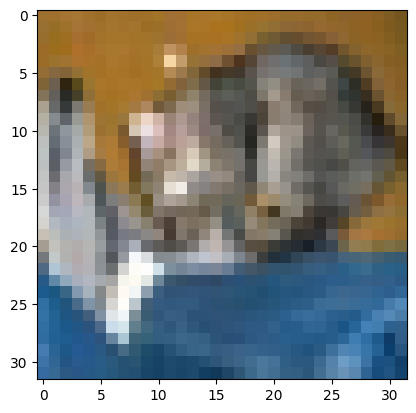

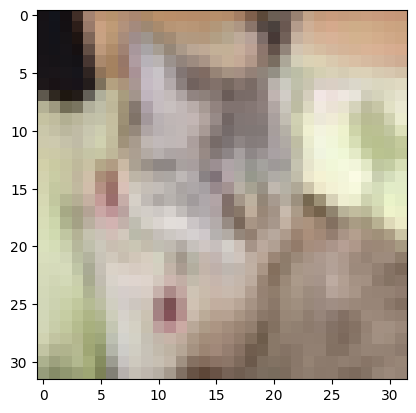

In [20]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cat_idxs = np.where((np.array(testset.targets) == 3))[0]
catset = torch.utils.data.Subset(testset, cat_idxs)
catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)


iterator = iter(catloader)
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))
images, _ = next(iterator)
imshow(torchvision.utils.make_grid(images.squeeze()))



In [21]:
l = len(catloader)
print(l)

1000


### Save images from test dataset

In [22]:
import shutil

In [23]:
test_folder = "test_images"
output_folder = os.path.join("output/", test_folder)
shutil.rmtree(output_folder)

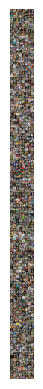

In [24]:
test_folder = "test_images"
output_folder = os.path.join("output/", test_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images = []
for i, (images, _) in enumerate(catloader):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid = torchvision.utils.make_grid(img_grid_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

## Saving data (shuffled) test dataset

Files already downloaded and verified


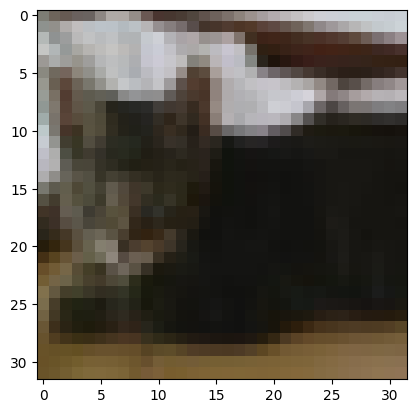

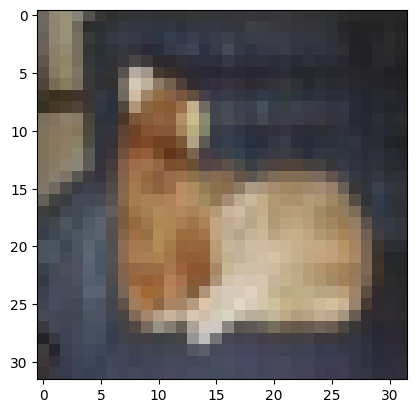

In [25]:
batch_size = 1
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cat_idxs = np.where((np.array(testset.targets) == 3))[0]
catset = torch.utils.data.Subset(testset, cat_idxs)
catloader2 = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)


iterator2 = iter(catloader2)
images, _ = next(iterator2)
imshow(torchvision.utils.make_grid(images))
images, _ = next(iterator2)
imshow(torchvision.utils.make_grid(images))

In [26]:
l = len(catloader2)
print(l)

5000


### Save images from train dataset

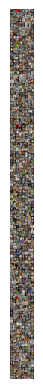

In [27]:
test_folder = "test_images_shuffled"
output_folder = os.path.join("output/", test_folder)
shutil.rmtree(output_folder)
os.makedirs(output_folder, exist_ok=True)

img_grid_images = []
for i, (images, _) in enumerate(catloader2):
  images = images.squeeze()
  if i<1000:
    images = images/2 + 0.5
    img_grid_images.append(images)
    image_path = os.path.join(output_folder, f"{i}.png")
    save_image(images, image_path)

img_grid = torchvision.utils.make_grid(img_grid_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

In [28]:
pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
!python -m pytorch_fid output/test_images_shuffled output/test_images
#should be ~0

100% 20/20 [00:06<00:00,  2.91it/s]
100% 20/20 [00:05<00:00,  3.78it/s]
FID:  49.837852159843465


# FID for 2xUD_halfchannels

In [ ]:
import types
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-UNet_2xUD_halfchannels"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet_2xUD_halfchannels"

999it [00:40, 24.73it/s]


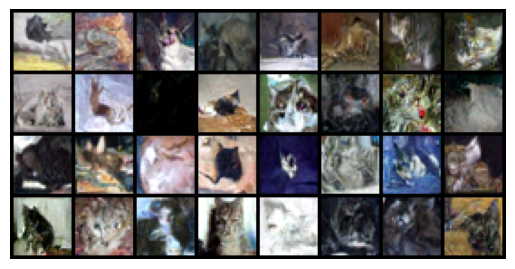

In [ ]:
# original structure


path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet().to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD().to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)


# structure reduced to 2x up down blocks
# args.run_name = "1e4lr"
# path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
# model = UNet_2xUD().to("cuda")

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
diffusion = Diffusion(img_size=args.image_size, device=args.device)

iarr = []
sampled_images = diffusion.sample(model, n=32, disable_bar=False, out=iarr)
img_grid = torchvision.utils.make_grid(sampled_images)
save_images(img_grid, os.path.join("output/", args.run_name, f"{uuid.uuid4()}.png"))

ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

### Saving Gen images to folder "halfChannel_images"

In [ ]:

args.folder_name = "halfChannel_images"
model.load_state_dict(torch.load(path))
diffusion = Diffusion(img_size=args.image_size, device="cuda")

sampled_images = diffusion.sample(model, n=num_images, disable_bar=False)


999it [01:45,  9.45it/s]


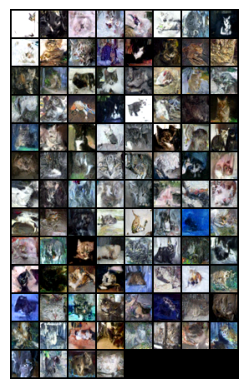

In [ ]:

# Create the output folder if it doesn't exist
output_folder = os.path.join("output/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()


### Doing the FID

In [ ]:
pip install pytorch-fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m pytorch_fid output/halfChannel_images output/test_images

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:04<00:00, 20.1MB/s]
100% 2/2 [00:01<00:00,  1.68it/s]
100% 2/2 [00:00<00:00,  2.44it/s]
FID:  225.87634287797115


# FID for UNet_2xUD

In [ ]:
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-UNet_2xUD"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet_2xUD"

In [ ]:
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device="cuda")
sampled_images = diffusion.sample(model, n=num_images, disable_bar=False)

999it [02:26,  6.81it/s]


### Adding generated Images to folder 2xUD_Images

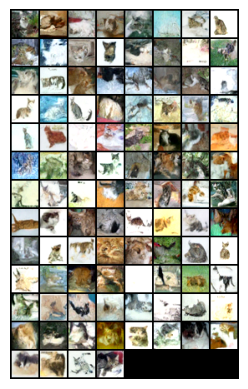

In [ ]:
args.folder_name = "2xUD_Images"
# Create the output folder if it doesn't exist
output_folder = os.path.join("output/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

## FID for 2xUD

In [ ]:
!python -m pytorch_fid output/2xUD_Images output/test_images

100% 2/2 [00:01<00:00,  1.88it/s]
100% 2/2 [00:00<00:00,  2.74it/s]
FID:  215.06817967820223


# FID for 3xBlocks

In [ ]:
args = types.SimpleNamespace()
args.run_name = "1024ep-16batch-3e4lr-3xblocks"
args.epochs = 1024
args.batch_size = 16
args.image_size = 32
if torch.cuda.is_available():
  args.device = "cuda"
else:
  args.device = "cpu"
args.lr = 3e-4
args.model = "UNet"

In [ ]:
path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
if (args.model == "UNet"):
    model = UNet(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD"):
    model = UNet_2xUD(device=args.device).to(args.device)
elif (args.model == "UNet_2xUD_halfchannels"):
        model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

if torch.cuda.is_available():
  model.load_state_dict(torch.load(path))
else:
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [ ]:
diffusion = Diffusion(img_size=args.image_size, device="cuda")
sampled_images = diffusion.sample(model, n=num_images, disable_bar=False)

999it [02:40,  6.21it/s]


### Adding generated Images to folder 3xblocks_Images

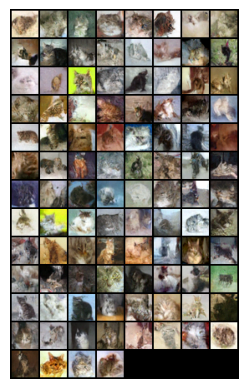

In [ ]:
args.folder_name = "3xblocks_Images"
# Create the output folder if it doesn't exist
output_folder = os.path.join("output/", args.folder_name)
os.makedirs(output_folder, exist_ok=True)

# Save each image individually
for i, image in enumerate(sampled_images):
    if i<num_images:
      image_path = os.path.join(output_folder, f"{i}.png")
      save_images(image, image_path)
    """
    if i<5:
      plt.figure()
      plt.imshow(image.permute(1,2,0).to('cpu').numpy())
    """

# Display the image grid
img_grid = torchvision.utils.make_grid(sampled_images)
ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
plt.figure()
plt.axis("off")
plt.imshow(ndarr)
plt.show()

## FID for 3xblocks

In [ ]:
!python -m pytorch_fid output/3xblocks_Images output/test_images

100% 2/2 [00:00<00:00,  2.27it/s]
100% 2/2 [00:00<00:00,  3.14it/s]
FID:  218.7717727811604


## Function definitions to make the above easier

In [ ]:
def save_test_images(num_images, folder_name):
  batch_size = 1
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
  cat_idxs = np.where((np.array(testset.targets) == 3))[0]
  catset = torch.utils.data.Subset(testset, cat_idxs)
  catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=False, num_workers=2)



  images, _ = next(iter(catloader))
  imshow(torchvision.utils.make_grid(images))
  test_folder = folder_name
  output_folder = os.path.join("output/", test_folder)
  os.makedirs(output_folder, exist_ok=True)

  img_grid_images = []
  for i, (images, _) in enumerate(catloader):
    if i<num_images:
      images = images/2 + 0.5
      img_grid_images.append(images[0])
      image_path = os.path.join(output_folder, f"{i}.png")
      save_image(images[0], image_path)

  img_grid = torchvision.utils.make_grid(img_grid_images)
  ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
  plt.figure()
  plt.axis("off")
  plt.imshow(ndarr)
  plt.show()

In [ ]:
def save_images_model(num_images, args, folder_name):
  path = os.path.join("models/CatDiffusion/", args.run_name, "ckpt.pt")
  if (args.model == "UNet"):
      model = UNet(device=args.device).to(args.device)
  elif (args.model == "UNet_2xUD"):
      model = UNet_2xUD(device=args.device).to(args.device)
  elif (args.model == "UNet_2xUD_halfchannels"):
          model = UNet_2xUD_halfchannels(device=args.device).to(args.device)

  if torch.cuda.is_available():
    model.load_state_dict(torch.load(path))
  else:
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

  diffusion = Diffusion(img_size=args.image_size, device="cuda")
  sampled_images = diffusion.sample(model, n=num_images, disable_bar=False)

  args.folder_name = folder_name
  # Create the output folder if it doesn't exist
  output_folder = os.path.join("output/", args.folder_name)
  os.makedirs(output_folder, exist_ok=True)

  # Save each image individually
  for i, image in enumerate(sampled_images):
      if i<num_images:
        image_path = os.path.join(output_folder, f"{i}.png")
        save_images(image, image_path)
      """
      if i<5:
        plt.figure()
        plt.imshow(image.permute(1,2,0).to('cpu').numpy())
      """

  # Display the image grid
  img_grid = torchvision.utils.make_grid(sampled_images)
  ndarr = img_grid.permute(1, 2, 0).cpu().numpy()
  plt.figure()
  plt.axis("off")
  plt.imshow(ndarr)
  plt.show()